# Accessing data
- __ERA5__:
    - ECMWF Reanalysis product, global product ~1960 onwards
    - project: rt52
    - directory: /g/data/rt52/era5/single-levels/reanalysis/
    - size: ~12GB for 2020, x37 levels for multiple level datasets
    - resolution: 0.25 degree resolution in netcdf files
    - 774 netcdf month files per variable
 
- __Intermediate Data__:
    - /scratch/en0/jwg574/ERA5/descriptive_name/...
    - daily maximums (saved to yearly files)
        - FFDI
        - DWI_V




In [1]:
## Imports
import xarray as xr
import numpy as np
import pandas as pd

import time
from glob import glob
import importlib
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)

import fio,plotting

In [2]:
## Dask
from dask.distributed import Client
client = Client()
print(client.dashboard_link)

/proxy/8787/status


In [7]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/simple_fire_metric/fio.py'>

## daily maximums
loop over months, calculate ffdi dwi and store into yearly file

In [3]:
#%%time
# ~ 53 mins for 20 years
# ~ 3GB RAM needed
latrange = fio.AU_LATRANGE
lonrange = fio.AU_LONRANGE
vars_for_ffdi = ['u10','v10','d2m','t2m']
years = range(1955,1956)
force_renew=False



if not os.path.isdir('/scratch/en0/jwg574/ERA5/daily_maximums/'):
    os.makedirs('/scratch/en0/jwg574/ERA5/daily_maximums/')

for year in years:
    fname = '/scratch/en0/jwg574/ERA5/daily_maximums/%4d.nc'%year
    if os.path.isfile(fname) and not force_renew:
        print("INFO: year %4d alread written at %s"%(year,fname))
        continue
    
    print("INFO: working on year ",year)
    ds_year = None
    da_ffdi_year = None
    da_dwi_year = None
    for month in np.arange(12)+1:
        # read month
        month_str='%4d-%02d'%(year,month)
        
        ds = fio.ERA5_read_month(vars_for_ffdi,month_str)
        # subset to AUS
        ds = ds.sel(latitude=slice(max(latrange),min(latrange)))
        ds = ds.sel(longitude=slice(min(lonrange),max(lonrange)))
        
        ## calc stuff
        ds = fio.calc_s10(ds)
        ds = fio.calc_rh(ds)
        ds = fio.calc_ffdi(ds)
        ds = fio.calc_DWI_V(ds)
        ds = fio.calc_ffdi_replacements(ds) # ffdi_f

        # daily resampling
        da_ffdi_max = ds.FFDI.resample(time='D').max()
        da_ffdif_max = ds.FFDI_F.resample(time='D').max()
        #da_ffdi_argmax = ffdi_daily.argmax()
        # keep driving vars for ffdi
        
        # calc dwi_v
        da_dwi_max = ds.DWI_V.resample(time='d').max()
        
        # keep driving vars for dwi_v
        
        # combine along time axis
        if da_ffdi_year is None:
            da_ffdi_year = da_ffdi_max
            da_ffdif_year = da_ffdif_max
            da_dwi_year = da_dwi_max
        else:
            da_ffdi_year = xr.concat([da_ffdi_year,da_ffdi_max],'time')
            da_ffdif_year = xr.concat([da_ffdif_year,da_ffdif_max],'time')
            da_dwi_year = xr.concat([da_dwi_year,da_dwi_max],'time')
            #print("INFO: ds_year:",ds_year)
    # store the year
    ds_year = da_ffdi_year.to_dataset()
    ds_year = ds_year.merge(da_ffdif_year)
    ds_year = ds_year.merge(da_dwi_year)
    ds_year.to_netcdf(fname)
    print("INFO: file saved: ",fname)


INFO: working on year  1955
INFO: file saved:  /scratch/en0/jwg574/ERA5/daily_maximums/1955.nc


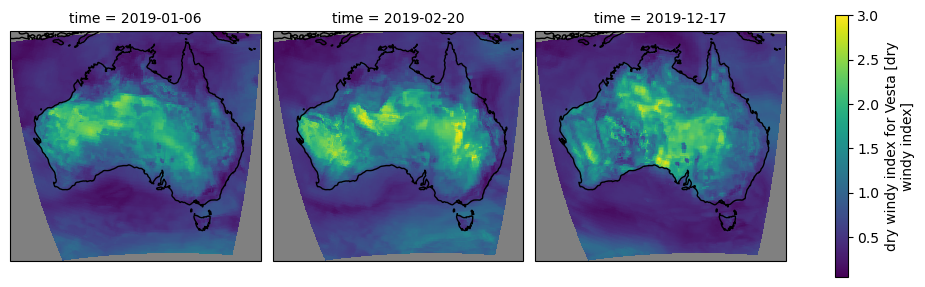

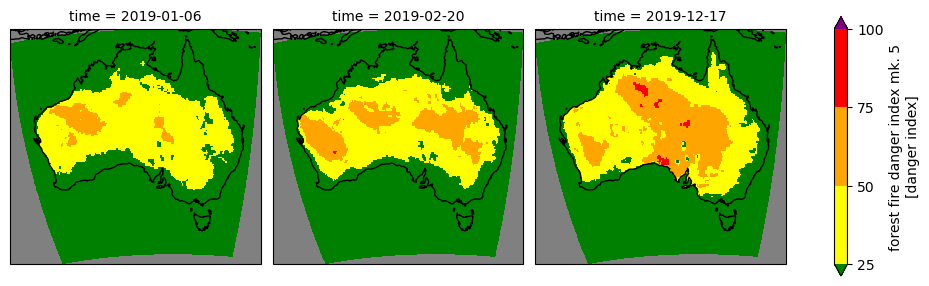

In [8]:
fname = '/scratch/en0/jwg574/ERA5/daily_maximums/2019.nc'
ds_year = xr.load_dataset(fname)
plotting.plot_quick(ds_year.DWI_V,itimes=[5,50,350])
plt.show()
plotting.plot_ffdi(ds_year.FFDI,itimes=[5,50,350])
plt.show()

## Save into one file (instead of yearly)

In [4]:
url_daily = "/scratch/en0/jwg574/ERA5/daily_maximums.nc"
url_yearly = "/scratch/en0/jwg574/ERA5/yearly_maximums.nc"

In [7]:
%%time
## all those daily maximums
all_daily = glob("/scratch/en0/jwg574/ERA5/daily_maximums/*.nc")
all_daily.sort()
ds_all_daily = xr.open_mfdataset(all_daily)
# need to delete it if it already exists
ds_all_daily.to_netcdf(url_daily)

CPU times: user 825 ms, sys: 20.4 s, total: 21.2 s
Wall time: 36.1 s


In [4]:
%%time
ds_all_daily = xr.open_dataset(url_daily)
ds_all_yearly = ds_all_daily.resample(time='AS').max()
ds_all_yearly.to_netcdf(url_yearly)

CPU times: user 28 s, sys: 15.4 s, total: 43.4 s
Wall time: 47.2 s


In [20]:
pre_2000 = ds_all_daily.where(ds_all_daily['time.year'] < 2000, drop=True)
post_2000 = ds_all_daily.where(ds_all_daily['time.year'] >= 2000, drop=True)


In [24]:
print(pre_2000.FFDI.shape)
print(post_2000.FFDI.shape)

(16436, 157, 177)
(7671, 157, 177)


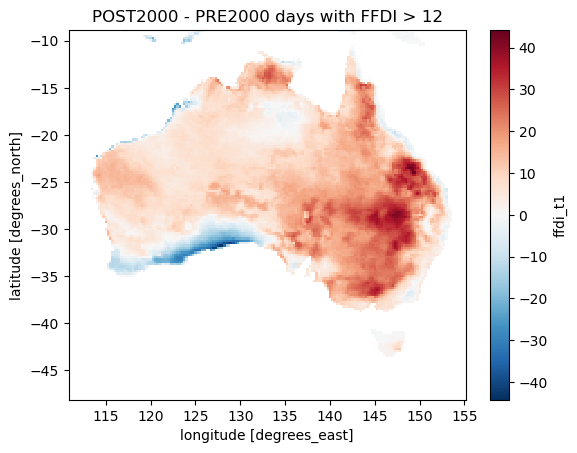

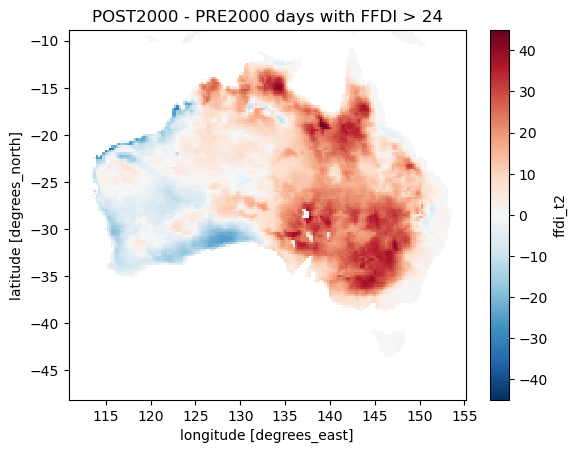

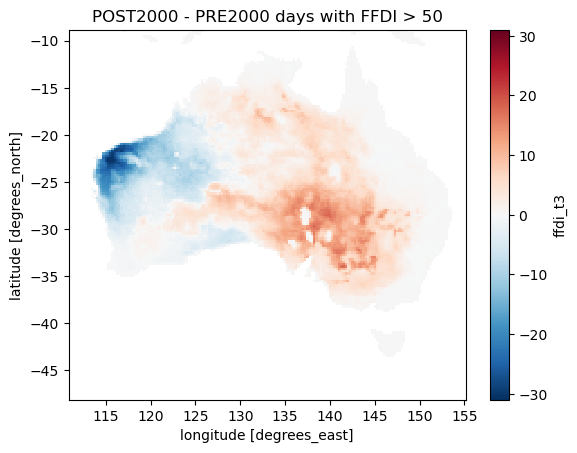

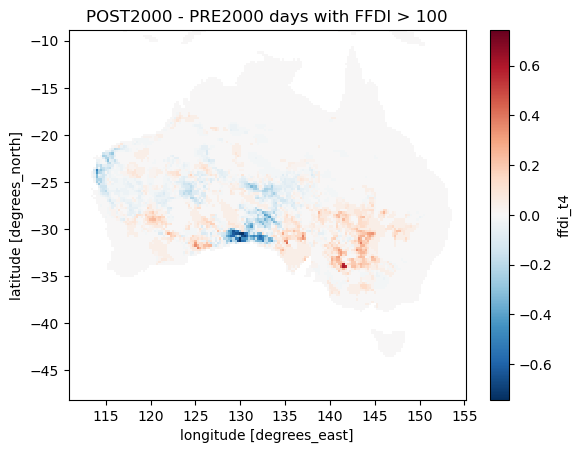

In [39]:
threshs = [12,24,50,100]
threshnames = 't1','t2','t3','t4'
ausmask = fio.get_landmask(pre_2000.FFDI)

for thresh,tname in zip(threshs,threshnames):
    pre_excedences = pre_2000.FFDI>thresh
    pre_excedences_per_year = pre_excedences.resample(time='AS').sum(dim='time').mean(dim='time')
    pre_2000['ffdi_%s'%tname] = pre_excedences_per_year
    
    post_excedences = post_2000.FFDI>thresh
    post_excedences_per_year = post_excedences.resample(time='AS').sum(dim='time').mean(dim='time')
    post_2000['ffdi_%s'%tname] = post_excedences_per_year

    # pre_2000['ffdi_%s'%tname].plot()
    # plt.title('PRE2000 days with FFDI > %d'%thresh)
    # plt.show()
    
    # post_2000['ffdi_%s'%tname].plot()
    # plt.title('POST2000 days with FFDI > %d'%thresh)
    # plt.show()
    
    (post_2000['ffdi_%s'%tname]-pre_2000['ffdi_%s'%tname]).where(ausmask).plot()
    plt.title('POST2000 - PRE2000 days with FFDI > %d'%thresh)
    plt.show()
    break
    


## Same but el-nino vs la nina vs neutral